# 目標：找出最適合用來預測員工是否離職的機器學習模型

### 使用的模型：
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

## 匯入套件並大概了解資料組成

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Downloads/HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


## 資料清理

In [5]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

### 清理重複列

In [6]:
df.duplicated().sum()

np.int64(3008)

In [7]:
df=df.drop_duplicates()

### 類別型轉換成數值

In [8]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['Department']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Department']))
df = pd.concat([df, encoded_df], axis=1).drop(columns=['Department'])

In [10]:
df=df.dropna()

In [11]:
df['salary']=df['salary'].map({'high':2, 'medium':1, 'low':0})

## 建立模型並進行預測和評估

## 1. *Logistic Regression*

In [72]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['left']) 
y = df['left']                
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
lr_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_pred))

Accuracy: 0.8218606591572799
Confusion Matrix:
 [[1906   93]
 [ 334   64]]


In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
lr_proba = lr.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_proba)
print(f"AUC: {lr_auc:.4f}")

AUC: 0.8236


In [81]:
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)
coeff_df

,Feature,Coefficient
0,satisfaction_level,-3.927923
5,Work_accident,-1.327009
12,Department_management,-0.666846
7,salary,-0.644007
1,last_evaluation,0.633874
6,promotion_last_5years,-0.606932
4,time_spend_company,0.315138
11,Department_hr,0.276738
2,number_project,-0.273267
9,Department_RandD,-0.255136


從邏輯回歸可知，影響是否離職最顯著的因素如上表所呈現

## 2. *Decision Tree*

In [37]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [71]:
dt_pred = dt.predict(X_test)
dt_prob = dt.predict_proba(X_test)[:, 1]

dt_acc = accuracy_score(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_prob)

print(f'Accuracy: {rf_acc:.4f}')
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print(f"AUC: {dt_auc:.4f}")

Accuracy: 0.9808
Confusion Matrix:
 [[1962   37]
 [  33  365]]
AUC: 0.9493


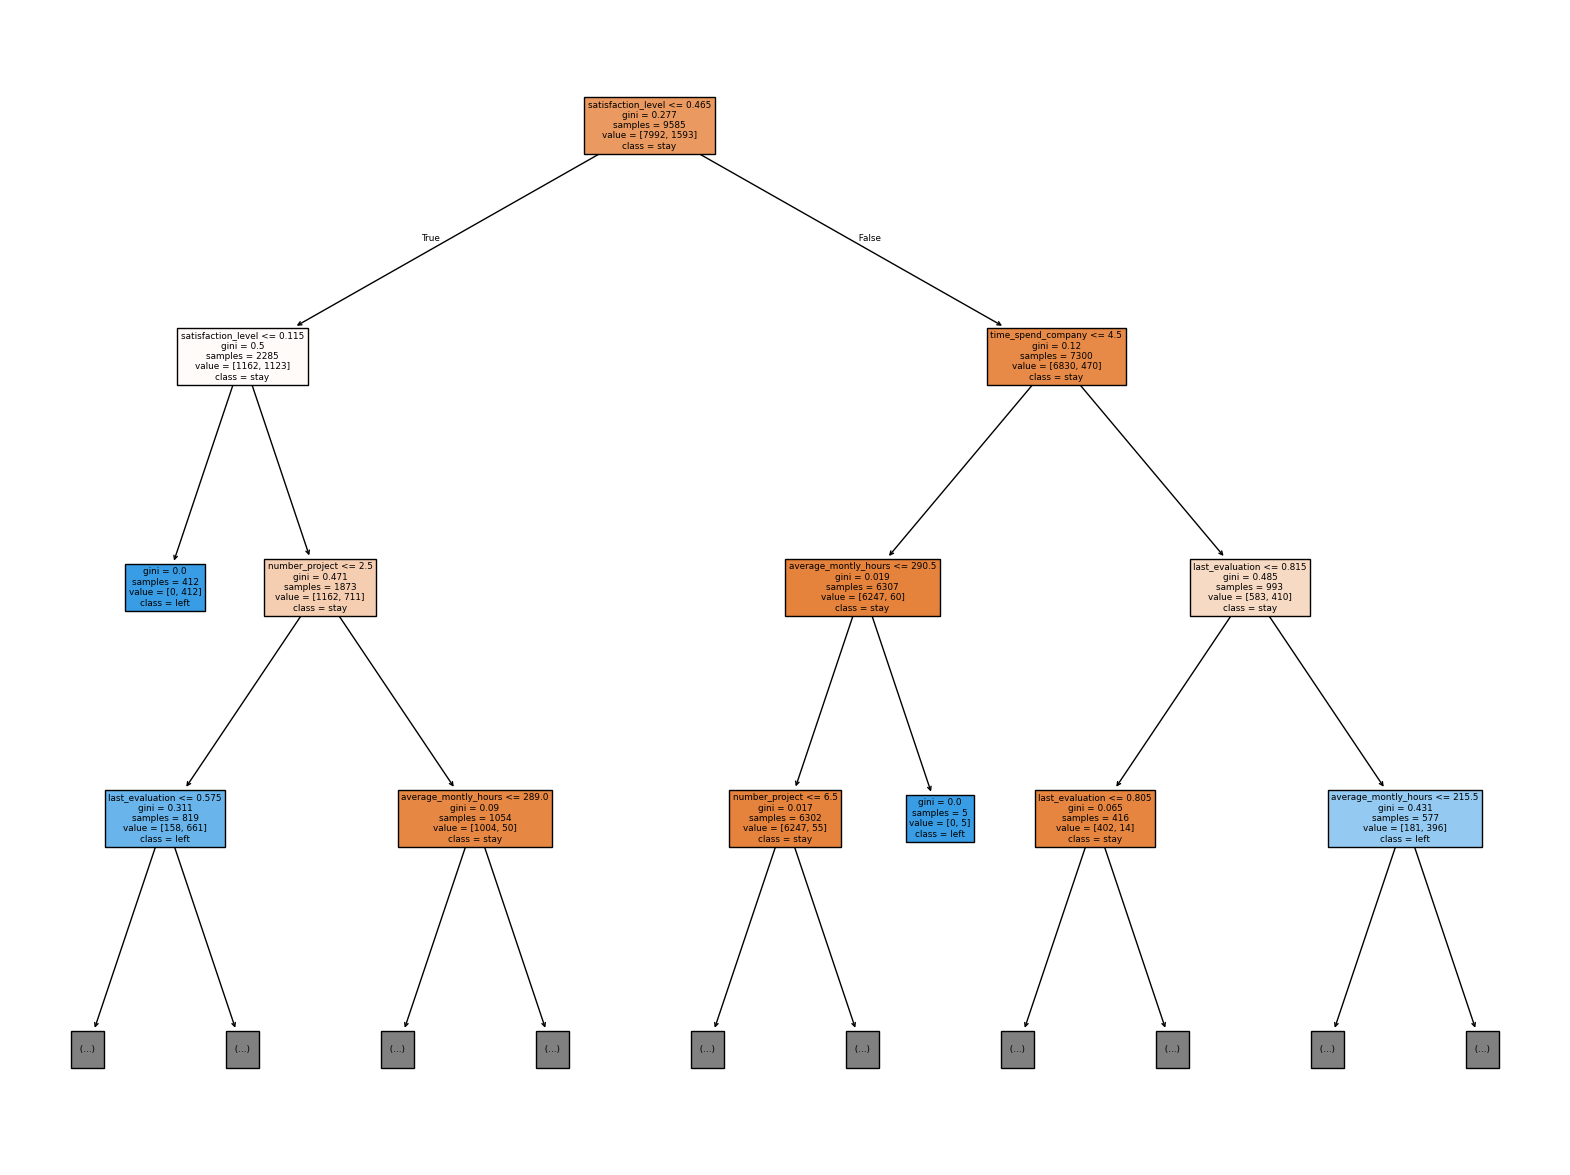

In [79]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,15))
plot_tree(dt, feature_names=X.columns, class_names=["stay", "left"], filled=True, max_depth=3)
plt.show()

由決策樹可看出影響員工離職的重要指標門檻

## 3. *Random Forest*

In [49]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [83]:
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba) 

print(f'Accuracy: {rf_acc:.4f}')
print('Confusion Matrix:\n', confusion_matrix(y_test, rf_pred))
print(f'AUC: {rf_auc:.4f}')

Accuracy: 0.9808
Confusion Matrix:
 [[1995    4]
 [  42  356]]
AUC: 0.9784


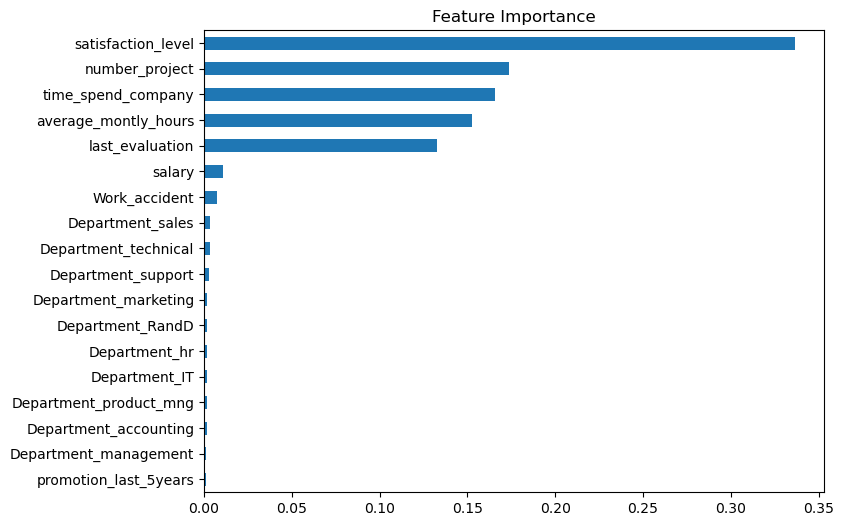

In [47]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title('Feature Importance')
plt.show()

## 4. *XGBoost*

In [87]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [88]:
xgb_proba = xgb.predict_proba(X_test)[:, 1]
xgb_pred = xgb.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_proba)

print(f'Accuracy:{xgb_acc:.4f}')
print('Confusion Matrix:\n', confusion_matrix(y_test, xgb_pred))
print(f"ROC AUC: {xgb_auc:.4f}")

Accuracy:0.9808
Confusion Matrix:
 [[1991    8]
 [  38  360]]
ROC AUC: 0.9770


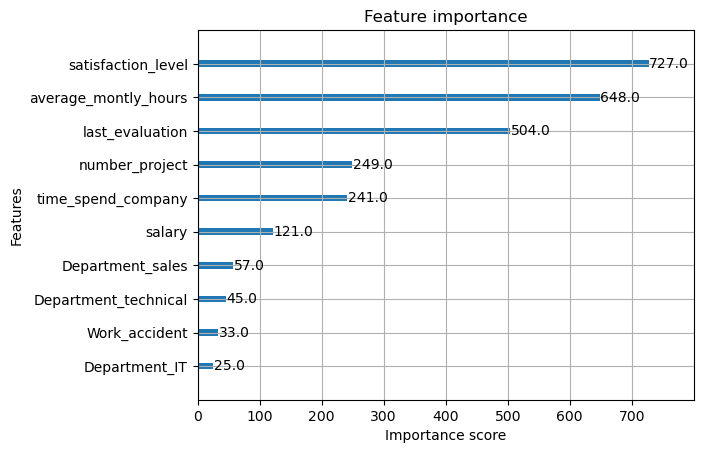

In [76]:
import xgboost
xgboost.plot_importance(best_model, max_num_features=10)
plt.show()

In [89]:
results={
    'methods': ['Logigstic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'auc': [lr_auc, dt_auc, rf_auc, xxx_auc]
}
final=pd.DataFrame(results).sort_values(by='auc', ascending=False)
final

,methods,auc
3,XGBoost,0.979854
2,Random Forest,0.978441
1,Decision Tree,0.949288
0,Logigstic Regression,0.823610


## 結論：透過AUC衡量模型的分類能力，其中XGBoost的表現最佳